# Multiple Class Classification - Earth Surface

In [1]:
# auto reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# contains all main external libraries
from fastai.conv_learner import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
# ensures we have a working NVidia GPU setup
torch.cuda.is_available()

True

In [5]:
# ensures NVidia accelerated functions available
torch.backends.cudnn.enabled

True

In [6]:
PATH = "data/planet/"
sz=224
arch = resnet34
bs = 64

In [7]:
# sets up the local validation set
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv))) -1 # turns variable into a list of rows without counting header
val_idxs = get_cv_idxs(n) #returns, by defailt, a random 20% of the data to use as the validation set

In [8]:
n # gives us the number of data entries in csv

40479

In [9]:
len(val_idxs) # gives us the number of data entries for validation

8095

## Initial Exploration of Data

In [10]:
!ls {PATH}

models	test-jpg  tmp  train-jpg  train_v2.csv


In [11]:
label_df = pd.read_csv(label_csv) # reads the csv file into the variable label_df using pandas

In [12]:
label_df.head() # outputs a preview of the label_df variable

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [13]:
# sets up the image transformations
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
# tells how to construct the data
data = ImageClassifierData.from_csv(PATH, 'train-jpg', f'{PATH}train_v2.csv', test_name='test-jpg', 
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [14]:
# grabs the first transformed image
fn = PATH + data.trn_ds.fnames[0]; fn

'data/planet/train-jpg/train_0.jpg'

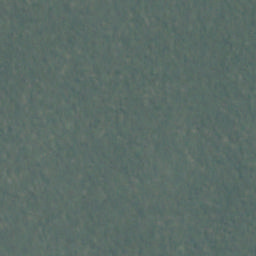

In [15]:
img = PIL.Image.open(fn).convert('RGB'); img

In [16]:
img.size

(256, 256)

In [17]:
# creates a dictionary comprehension that maps the name of the file to the size of the file
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [18]:
# turns dictionary into rows and columns
row_sz, col_sz = list(zip(*size_d.values()))

In [19]:
# turns the rows and columnbs into numpy arrays
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [20]:
# first five row sizes for images
row_sz[:5]

array([256, 256, 256, 256, 256])

In [21]:
# first five column sizes for images
col_sz[:5]

array([256, 256, 256, 256, 256])

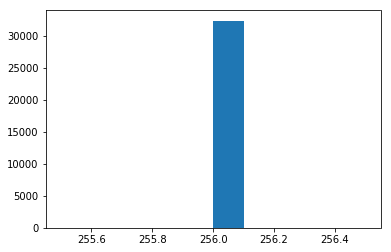

In [22]:
plt.hist(row_sz); # uses matplotlib to show the number of images by height (rows in image)

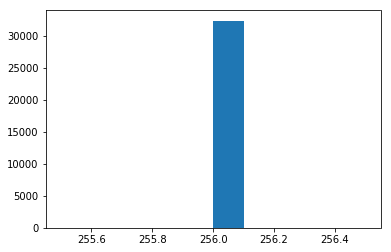

In [23]:
plt.hist(col_sz); # plots the number of images by horizontal size

In [24]:
col_sz[:5]

array([256, 256, 256, 256, 256])

In [25]:
len(data.trn_ds), len(data.test_ds)

(32384, 40669)

In [26]:
len(data.classes), data.classes[:5]

(17, ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down'])

In [27]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [28]:
# finds learning rate
lrf = learn.lr_find()

epoch      trn_loss   val_loss   <lambda>                    
    0      0.205174   0.265337   0.940225  



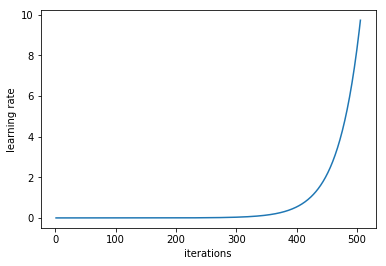

In [29]:
learn.sched.plot_lr()

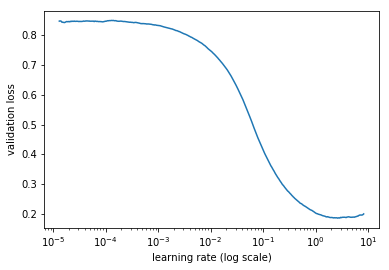

In [30]:
learn.sched.plot()

In [31]:
# picked a learning rate where the rate was still improving
learn.fit(0.1, 3)

epoch      trn_loss   val_loss   <lambda>                    
    0      0.134327   0.114677   0.956146  
    1      0.122181   0.110705   0.957628                    
    2      0.122725   0.109149   0.958427                    



[array([0.10915]), 0.9584274957031288]

In [32]:
learn.precompute=False

In [33]:
learn.fit(0.1, 3, cycle_len=1)

epoch      trn_loss   val_loss   <lambda>                    
    0      0.120731   0.105951   0.959154  
    1      0.121093   0.10543    0.959837                    
    2      0.120069   0.104802   0.960259                    



[array([0.1048]), 0.9602586911223862]

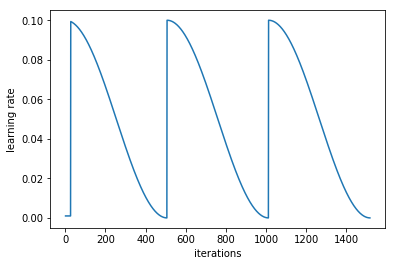

In [34]:
learn.sched.plot_lr()

In [35]:
learn.save('224_all')

In [36]:
learn.load('224_all')

In [37]:
learn.unfreeze()

In [38]:
learn.fit([0.01, 0.03, 0.1], 3, cycle_len=2)

epoch      trn_loss   val_loss   <lambda>                    
    0      0.104112   0.092193   0.96459   
    1      0.098207   0.089451   0.965512                     
    2      0.096028   0.087826   0.966406                     
    3      0.093884   0.08574    0.967162                     
    4      0.095027   0.085811   0.967024                     
    5      0.091174   0.084618   0.967111                     



[array([0.08462]), 0.9671111414578316]

In [39]:
learn.fit([1e-4, 1e-3, 0.01], 4)

epoch      trn_loss   val_loss   <lambda>                     
    0      0.087017   0.084375   0.967496  
    1      0.090237   0.084161   0.967416                     
    2      0.089109   0.084297   0.967562                     
    3      0.089159   0.084074   0.967329                     



[array([0.08407]), 0.9673291457663943]

## Testing

In [47]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than vaidation dataset
probs = np.mean(np.exp(log_preds), 0)

In [48]:
probs.shape # (n_images, n_classes)

(40669, 17)

In [49]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [50]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [51]:
df.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,2.618070,1.000338,1.012932,1.000367,1.000941,1.014948,1.000300,1.001591,1.637937,1.211332,1.001875,2.683295,2.713653,1.105450,1.000520,1.019762,1.033416
1,1.751855,1.000613,1.030214,1.011503,1.002357,2.652679,1.000438,1.000794,1.776099,2.152245,1.032791,1.003116,2.712479,1.283044,1.027049,1.016851,1.030078
2,2.634489,1.000028,1.004837,1.000367,1.000316,2.514838,1.000484,1.000310,1.109384,1.051248,1.033630,1.018474,2.694787,1.890478,1.000311,1.001413,1.274228
3,1.623418,1.005654,1.062391,1.000668,1.000292,2.712635,1.000139,1.001604,1.148938,1.117747,1.002196,1.001058,2.712657,1.281411,1.001164,1.002722,2.678603
4,1.006723,1.000089,1.000355,1.000449,1.000187,1.006710,1.454632,1.000072,1.001345,1.000848,1.564799,1.073355,1.947905,1.002244,1.000160,1.000104,1.007098


In [52]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [53]:
FileLink(f'{SUBM}subm.gz')

/home/paperspace/fastai/courses/dl1/data/planet/subm/subm.gz